<a href="https://colab.research.google.com/github/hyunsoo41/Umi/blob/main/Umi_Phoodrecipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Phoodrecipe(CNN food classifier & recipe printer)

* Add all the imports

In [ ]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [ ]:
# Clone tensorflow/examples repo which has images to evaluate trained model
!git clone https://github.com/tensorflow/examples.git

fatal: destination path 'examples' already exists and is not an empty directory.


In [ ]:
# Helper function to download data and extract

def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

* The Food-101 dataset is 5GB in size. This might take some time to finish..

In [ ]:
# Download data and extract it to folder
get_data_extract()

Dataset already exists


In [ ]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    #print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
#print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')


Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying images into  croque_madam

In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
#print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Copying Done!


In [ ]:
# Check how many files are in the train folder

train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [ ]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


# Create a subset of data with few classes (3)

In [ ]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
# picking 3 food items and generating separate data folders for the same
food_list = ['apple_pie','pizza','omelette']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101/train_mini")])
print(train_files)

Total number of samples in train folder
2250


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101/test_mini")])
print(test_files)

Total number of samples in test folder
750


# Fine tune Inception Pretrained model using Food 101 dataset

* Keras and other Deep Learning libraries provide pretrained models  
* These are deep neural networks with efficient architectures(like VGG,Inception,ResNet) that are already trained on datasets like ImageNet  
* Using these pretrained models, we can use the already learned weights and add few layers on top to finetune the model to our new data  
* This helps in faster convergance and saves time and computation when compared to models trained from scratch

* We currently have a subset of dataset with 3 classes - samosa, pizza and omelette  
* Use the below code to finetune Inceptionv3 pretrained model

In [ ]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session() 
  # 이 함수를 호출할 때마다 연산 그래프를 실행하므로 모델의 학습속도가 느려지고 메모리가 부족할 수 있다.
  # 이 때 이 함수를 호출하면 모델 생성전에 tensorflow의 graph 영역을 clear한다.

  img_width, img_height = 299, 299 #이미지 크기를 299x299로 설정
  train_data_dir = 'food-101/train_mini' #train data 경로, 2250장
  validation_data_dir = 'food-101/test_mini' #test data 경로, 750장
  batch_size = 16  #train data 중 한번에 넘겨주는 데이터의 수가 16, 
  #epoch는 전체 데이터 셋에 대해 forward pass + backward pass가 완료된 것! (헷갈 노노)

  #파일경로
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)
  #data argument 해주는 함수 ImageDataGenerator, 가지고 있는 데이터들을 여러 방법으로 변형시켜 더 많은 데이터 사용할 수 있음
  #preprocessing_function=preprocess_input: 모델에 필요한 형식에 이미지를 적절하게 맞추기 위한 것, 모든 input 이미지에 각각 적용함
  #shear_range: 0.2 radian 내외로 시계반대방향으로 변형시켜줌
  #zoom_range: 원본이미지를 0.8배부터 1.2배 크기 변화 시켜줌
  #horizontal_flip: 좌우 반전

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')
  #flow_from_directory는 directory 경로로부터 data frame을 가져와서(첫번째 인자) augmented 또는 normalized 된 data 배치를 생성하는 함수
  #target_size=(img_height, img_width)로 지정된 크기로 이미지를 조정한다.
  #classmode는 분류 방식 지정해주는 인자인데 여기서는 categoraical로 반환

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  inception = InceptionV3(weights='imagenet', include_top=False)
  #사전 훈련된 모델을 가져옴, imagenet(dataset)으로 pretrained 된 model 사용
  #inceptionv3는 48개 계층으로 구성된 컨벌루션 신경망, imgaenet 데이터베이스의 1백만 개가 넘는 영상에 대해 훈련된 신경망의 사전 훈련된 버전을 불러올 수 있음
  #사전 훈련된 신경망은 1,000가지 사물 범주로 분류할 수 있음
  #신경망의 영상 입력 크기는 299*299 (그래서 위에서 사진 크기를 299x299로 한 것임)
  x = inception.output
  x = GlobalAveragePooling2D()(x) #공간적 데이터에 대한 최대값 풀링 작업, 전체 영역에 대한 pooling, 레이어 집합을 input으로 하여 벡터를 output으로 낸다. output은 결국 feature의 개수만큼.
  x = Dense(128,activation='relu')(x) #입력과 출력을 모두 연결해 주는 함수 Dense, 128개의 출력 뉴런, 활성화 함수는 relu
  x = Dropout(0.2)(x) #전체 입력 값 중 20%를 0으로 만듦, 과적합 방지

  predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)
  #분류하는 클래스의 개수 n_classes
  #kernel_regularizer: 가중치가 지나치게 커지지 않도록 정규화항 추가해줌(가중치가 커지면 손실 커짐), l2는 L2 정규화(가중치의 제곱을 손실함수에 추가)를 해줌
  #활성화 함수로 softmax함수 사용


  #모델을 가져와서 컴파일 함.
  model = Model(inputs=inception.input, outputs=predictions) 
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])  #모델 학습 과정 설정
 
  #모델 학습 시 필요한 callbacks 인자 요소 
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  #filepath: 모델 파일을 저장할 경로.
  #verbose: 학습 진행 상황 보이게 설정(0이면 보이지 않음)
  #save_best_only = True를 설정하면 모델의 가중치만 저장되고, 아닌 경우 전체 모델이 저장됨 

  csv_logger = CSVLogger(history_path)
  #결과를 csv 파일에 스트림하는 콜백.

  #모델 학습시키는 함수 model.fit_generator. (generator로 생성된 배치 학습시에 이 함수를 사용함.)
  history = model.fit_generator(train_generator, #훈련 데이터 셋
                      steps_per_epoch = nb_train_samples // batch_size, #한 epoch에 사용한 step 수
                      validation_data=validation_generator, #테스트 데이터 셋 
                      validation_steps=nb_validation_samples // batch_size, #한 epoch 종료시마다 검증할 때 사용되는 검증 step 수
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint]) #모델의 내적 상태 & 통계자료 확인 가능 

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  #class_indices 출력하면 해당 열의 클래스명 알려줌
  return history, class_map

In [ ]:
# Train the model with data from 3 classes
n_classes = 3
epochs = 5 #임의로 지정
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_3 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_3)

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
140/140 [==============================] - 63s 411ms/step - loss: 1.1440 - accuracy: 0.3845 - val_loss: 0.8901 - val_accuracy: 0.6780

Epoch 00001: val_loss improved from inf to 0.89015, saving model to bestmodel_3class.hdf5
Epoch 2/30
140/140 [==============================] - 57s 403ms/step - loss: 0.8842 - accuracy: 0.6465 - val_loss: 0.6885 - val_accuracy: 0.7921

Epoch 00002: val_loss improved from 0.89015 to 0.68851, saving model to bestmodel_3class.hdf5
Epoch 3/30
140/140 [==============================] - 57s 404ms/step - loss: 0.7320 - accuracy: 0.7276 - val_loss: 0.5617 - val_accuracy: 0.8383

Epoch 00003: val_loss improved from 0.68851 to 0.56167, saving model to bestmodel_3class.hdf5
Epoch 4/30
140/140 [==============================] - 57s 403ms/step - loss: 0.6058 - accuracy: 0.7914 - val_loss: 0.4657 - val_accuracy: 0.8709

Epoch 00004: val_loss improved from 0.56167 to 0.46568, saving model to bestmodel_3class.hdf5
Epoch 5/30
140/140 [========================

# Visualize the accuracy and loss plots

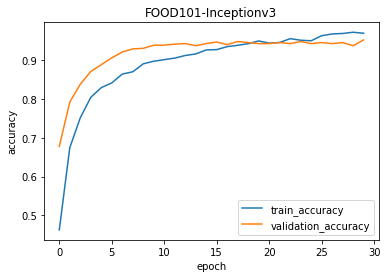

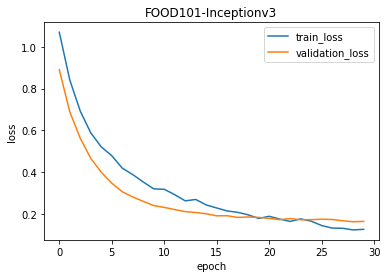

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

* The plots show that the accuracy of the model increased with epochs and the loss has decreased
* Validation accuracy has been on the higher side than training accuracy for many epochs
* This could be for several reasons:
  * We used a pretrained model trained on ImageNet which contains data from a variety of classes
  * Using dropout can lead to a higher validation accuracy
* The best model saved has a Top-1 validation accuracy of 93%
 


# Predicting classes for new images from internet using the best trained model

In [ ]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('bestmodel_3class.hdf5',compile = False)

CPU times: user 1.75 s, sys: 60.7 ms, total: 1.81 s
Wall time: 1.79 s


* **Setting compile=False and clearing the session leads to faster loading of the saved model**
* **Withouth the above addiitons, model loading was taking more than a minute!**

In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = preprocess_input(img)                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    #print(pred)
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()
    
    if (os.path.isfile('/content/%s.txt'%pred_value)): # os.path.isfile 을 사용해서 해당 위치에 예측된 음식명(pred_value)과 같은 이름의 레시피가 존재하면 (이 레시피 파일은 미리 해당 폴더에 추가해놓음)
      with open('/content/%s.txt'%pred_value) as file_object: # 그 파일을 읽어온다.
        contents = file_object.read()
        print(contents)
    else:
      print("Sorry, we have no recipe.") # 일치하는 레시피가 존재하지 않다면 없다는 문구 출력
  

In [1]:
# Make a list of images and test the trained model
!wget -O samosa.jpg http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
!wget -O applepie.jpg https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
images = []
#imagepath = '/content/examples/community/en/multi_class_classification/images/'
#images.append(imagepath+'samosa.jpg')

--2021-05-23 10:57:52--  http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Resolving veggiefoodrecipes.com (veggiefoodrecipes.com)... 62.75.168.50
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|62.75.168.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75560 (74K) [image/jpeg]
Saving to: ‘samosa.jpg’

samosa.jpg          100%[===================>]  73.79K  --.-KB/s    in 0.04s   

2021-05-23 10:57:52 (1.64 MB/s) - ‘samosa.jpg’ saved [75560/75560]

--2021-05-23 10:57:52--  https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
Resolving acleanbake.com (acleanbake.com)... 138.197.203.41
Connecting to acleanbake.com (acleanbake.com)|138.197.203.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114276 (112K) [image/jpeg]
Saving to: ‘applepie.jpg’

applepie.jpg        100%[===================>] 111.60K   402KB/s    in 0.3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


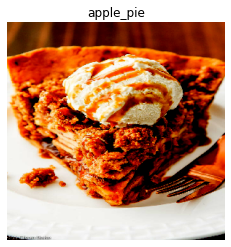

-애플파이 레시피-

재료
[파이]
박력분 200g
소금 1/8ts
설탕 5g
차가운 버터 100g
계란 1개
[사과필링]
사과2게
설탕 또는 황설탕 60g
버터 25g
옥수수전분 1Ts
계피가루 1/4ts
계란물(노른자1개+물1Ts)

준비해두세요
· 박력분은 체 쳐 둡니다.
· 버터는 냉장고에 두고 차갑게 해 콩알크기로 다져둡니다.
· 사과는 1cm크기로 깍뚝썰기 해 둡니다.

STEP 1 : (8분 소요 예상)
[파이]
박력분에 소금, 설탕을 넣고 섞은 뒤 버터를 넣고 도우블렌더로 잘 섞습니다.
(도우블렌더가 없으면 양손으로 비벼 고슬고슬하게 합니다)

STEP 2 : (5분 소요 예상)
가운데 홈을 파고 그 안에 계란을 넣은 뒤 손으로 치댑니다.

STEP 3 : (3분 소요 예상)
작업대로 옮겨 완전히 한덩어리가 되도록 합니다.
(너무 오래 치대지 않습니다)

STEP 4 : (60분 소요 예상)
반죽을 납작하게 하여 랩이나 비날에 싼 후 냉장실에 1시간 둡니다.

STEP 5 : (4분 소요 예상)
[필링]
냄비에 설탕을 넣고 중불에 녹인 후 버터를 넣어 잘 섞습니다.

STEP 6 : (10분 소요 예상)
버터가 녹으면 바로 사과를 넣고 바닥부분이 눌지 않도록 잘 저으며 졸입니다.
(중불에서 약10분정도)

STEP 7 : (3분 소요 예상)
어느정도 사과가 졸으면 전분과 계피가루를 넣고 2분정도 더 졸인 후 다른볼에 담아 식힙니다.

STEP 8 : (5분 소요 예상)
작업대에 비닐을 깔고 밀대를 이용하여 두께 약3mm정도로 밉니다.
(반죽이 질면 분량외 밀가루를 뿌려가며 밀어주세요)

STEP 9 : (5분 소요 예상)
팬위에 반죽을 올린 뒤 반죽을 최대한 밀착시키고 가장자리를 눌러 남은 반죽을 잘라내고 손가락으로 밀착시키면서 다듬습니다.

STEP 10 : (5분 소요 예상)
남은 반죽은 다시 3mm두께로 밀어 약1cm간격으로 자릅니다.

STEP 11 : (5분 소요 예상)
틀에 필링을 담고 가장자리에 물칠을 한 후 잘라 놓은 반죽을 격자로

In [ ]:
images.append('applepie.jpg')
predict_class(model_best, images, True)